# Coursera Final Capstone for IBM Datascience Professionals
### Bathe of Neighboarhoord: Comparative Analysis of two Finacials districts Neighboarhood (Dwontown Toronto/Canada and Manhattan/USA)

## Table of contents
* [Introduction: The Idea](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Mapping Clusters](#clustersmap)

## Introduction: The Idea <a name="introduction"></a>

In This project i will make a comparative analysis beetween two Financial Districts area in the world. The key question will be how are their Neighborhodd are structured and diversify:

* **What Level of diversity?** Throught inertia of clusters and number of possible clusters we will analyse the 2 places Naighorhood.
* **What structure?** Throught the caracteristics of the cluster we could say how the Neighboardhoo is structured?

On a final i will discuss the result and open perspectives for other further analysis.

I choose  Downtown toronto(Canada) and Manhattan (USA) for the study.

## Data <a name="data"></a>

For This study we will use New York and Toronto data, combine to Foursquare API data:

* **New York Data** : 
We will essentially need a dataset that contains  boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. These information are in a dataset provided as json file. From this file will make a pandas dataframe and use it for the study.
* **Toronto Data** : 
We will need the same kind of informations as for New York city. For that perpose we will scrap the information from the web, more precisely from <a href =" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" > Wikipedia</a>. We will transform this data into a Pandans dataframe and use it for the study.
* **Geospatial Cordinate** : 
The data from wikipedia have not geo information. We will use a file provide for the course. In this file we have some geo information that we are going to take to complete wikipedia informations through a join operation.
* **Foursquare** : 
For square API will provide the venues around the neighborhoods we will provide. The will merge those informations the NewYork and Toronto data for the study.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
#importing necessry bibl for scraping data from wikipedia
import urllib.request
import re
from bs4 import BeautifulSoup
import csv


import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests # library to handle requests
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


### Toronto Data (Downtown Toronto Neighboardhood)

####  1 - Scraping Data from wikipedia to a csv file

In [2]:
#Setting Variables
canada_pc_url =" https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = open('canada_pc_data.csv','w+')

try:
        updcsv = csv.writer(data) 
        updcsv.writerow(('PostalCode','Borough','Neighborhood'))
        url = urllib.request.urlopen(canada_pc_url).read() 
        print("Lien : "+canada_pc_url)
        soupe = BeautifulSoup(url)
        tableau = soupe.find("table", {"class":"wikitable sortable"}) 
        lignes = tableau.findAll("tr") 
        for ligne in lignes:
            PostalCodes = ligne.findAll("td") 
            if PostalCodes:
                    PostalCode = PostalCodes[0].get_text() 
                    Borough = PostalCodes[1].get_text()
                    Neighborhood = PostalCodes[2].get_text()
                    # Here i replace Not assigned by Nan so i could treat it as null value further (this is a choice) and remove line break symbol (\n) from Borough data
                    updcsv.writerow((PostalCode,Borough.replace('Not assigned','NaN'),Neighborhood.replace('\n',''))) 
finally:
        data.close()

Lien :  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/envs/DSX-Python35/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


 #### 2 - Creating pandas dataframe with csv data and Wrangling for proper dataframe

* ##### Creating pandas dataframe

In [3]:
df=pd.read_csv('canada_pc_data.csv')

* ##### Wrangling data


We are going to :
       - remove data with null Borough;
       - Replace Null Neighborhood with the Borough
       - Group data by PostalCode and Borought

In [4]:
# droping NaN in "Borough" column
df.dropna(subset=["Borough"], axis=0, inplace=True)
#replacing null Neighbohood column by Borough column
df["Neighborhood"].replace("Not assigned", df["Borough"], inplace=True)
# reseting index, because we droped rows
df.reset_index(drop=True, inplace=True)
df=df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

#### 3 -  Completing wikipedia information with a Geospatial Cordinates

* #####  Creating pandas df with geo informations/ I use the provided file as the API seems to not working properly

In [5]:
!wget -O Geospatial_Cordinate.csv http://cocl.us/Geospatial_data
geo_df=pd.read_csv('Geospatial_Cordinate.csv')


--2019-04-15 12:55:51--  http://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.48.113.201
Connecting to cocl.us (cocl.us)|169.48.113.201|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cocl.us/Geospatial_data [following]
--2019-04-15 12:55:51--  https://cocl.us/Geospatial_data
Connecting to cocl.us (cocl.us)|169.48.113.201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-04-15 12:55:51--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-04-15 12:55:52--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjc

* #####  Creating a new df that merge wikipedia data and Geospatial data

In [6]:
#renaming 'Postal Code' in geo_df to match 'PostalCode'  in df
geo_df = geo_df.rename(columns={'Postal Code': 'PostalCode'})
#making a left join operation to merge the two pd
final_df = pd.merge(df,
                 geo_df[['PostalCode','Latitude','Longitude']],
                 on='PostalCode', 
                 how='left')

In [7]:
#Filtering df on Downtown Toronto
Downtown_Toronto_data = final_df[final_df['Borough']=='Downtown Toronto'].reset_index(drop=True)
Downtown_Toronto_data=Downtown_Toronto_data.drop(['PostalCode'],axis=1)
Downtown_Toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Rosedale,43.679563,-79.377529
1,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### New York Data (Manathan Neighborhood)

#### 1- Downloading json file and saving it

In [8]:
# Downloading json file
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [9]:
# Saving data as newyork_data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

#### 2- Wrangling json data and creating Manhathan neighborhood dataframe

In [10]:
#Taking features branche of the json file as neighborhoods_data
neighborhoods_data = newyork_data['features']

In [11]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)


In [12]:
#Spliting geoInformations into longitude and latitude and appending them to df
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [13]:
#Filtering on manhattan
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Foursquare : Completing data with venues 

#### 1 - Setting credentials for Foursquare API

In [14]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = 'xxxx'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


#### 2 - Creating dataframe with venue informations

Before all Let's define a fonction to create dataframe with venue informations

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### a - Downtown Toronto

* ######  Creating Toronto_venues dataframe


Here we are going to create a dataframe with the data and moreover we will make some changements in the name of venues categories. The names are very diverses but sometime different names refers to the same category (Ex. Coffee Shop an Café). In a other and i choose to put some categories together (Ex. Restaurants==>I choose a continent axis and not a country axis).

In [16]:
Downtown_Toronto_venues = getNearbyVenues(names=Downtown_Toronto_data['Neighborhood'],
                                   latitudes=Downtown_Toronto_data['Latitude'],
                                   longitudes=Downtown_Toronto_data['Longitude']
                                  )

Downtown_Toronto_venues_1=Downtown_Toronto_venues['Venue Category']
Downtown_Toronto_venues=Downtown_Toronto_venues.replace(to_replace=['Indian Restaurant','Taiwanese Restaurant','Chinese Restaurant','Japanese Restaurant','Thai Restaurant','Ramen Restaurant','Sushi Restaurant','Dumpling Restaurant','Filipino Restaurant','Vietnamese Restaurant','Korean Restaurant','Dim Sum Restaurant','Asian Restaurant']
                            ,value ="Asian Restaurant").replace(to_replace=['Italian Restaurant','French Restaurant','Modern European Restaurant','Portuguese Restaurant','German Restaurant','Belgian Restaurant','Greek Restaurant','Restaurant','Italian Restaurant']
                            ,value ="European Restaurant").replace(to_replace=['Ethiopian Restaurant']
                            ,value ="African Restaurant").replace(to_replace=['Taco Place','Steakhouse','Soup Place','Sandwich Place','Salad Place','Fried Chicken Joint','Food Court','Food Truck','Pizza Place','Snack Place','Comfort Food Restaurant','Diner','Theme Restaurant','Doner Restaurant','Fast Food Restaurant','Molecular Gastronomy Restaurant','Mediterranean Restaurant','Seafood Restaurant','Vegetarian / Vegan Restaurant','Gluten-free Restaurant']
                            ,value="Other Food Place").replace(to_replace=['Middle Eastern Restaurant','Falafel Restaurant','Afghan Restaurant']
                            ,value="Midle East Restaurant").replace(to_replace=['Colombian Restaurant','Mexican Restaurant','Latin American Restaurant','Brazilian Restaurant']
                            ,value="Latin American Restaurant").replace(to_replace=['New American Restaurant','American Restaurant']
                            ,value="American Restaurant").replace(to_replace=['Gym','Gym Pool',' Athletics & Sports','Basketball Stadium', 'Baseball Stadium', 'Gym / Fitness Center']
                            ,value="Sport place").replace(to_replace=[ 'College Arts Building','College Gym', 'College Rec Center']
                            ,value="School/Education").replace(to_replace=[ 'Supermarket','Adult Boutique','Bagel Shop','Bubble Tea Shop','Cupcake Shop','Food & Drink Shop','Antique Shop','Chocolate Shop','Coffee Shop','Comic Shop','Cosmetics Shop','Dessert Shop','Donut Shop','Gourmet Shop','Hobby Shop','Ice Cream Shop','Miscellaneous Shop','Optical Shop','Record Shop','Salon / Barbershop','Shopping Mall','Smoke Shop','Smoothie Shop','Sporting Goods Shop','Tailor Shop','Cheese Shop','Discount Store','Electronics Store','Clothing Store', 'Gift Shop','Furniture / Home Store','Shoe Store','Toy / Game Store','Video Game Store','"Mens Store"','Accessories Store','Arts & Crafts Store','Baby Store','Beer Store','Bookstore','Camera Store','Convenience Store','Department Store','Health Food Store','Jewelry Store','Lingerie Store','Liquor Store','Pet Store','Thrift / Vintage Store']
                            ,value="Shop/Store").replace(to_replace =['Organic Grocery','Grocery Store']
                            ,value ="Grocery").replace(to_replace =['Hostel','Hotel','Hotel Bar']
                            ,value ="Hotel").replace(to_replace =['Art Gallery','Art Museum','Monument / Landmark','History Museum','Performing Arts Venue','Sculpture Garden']
                            ,value ="Art/Museum").replace(to_replace =['Airport Lounge', 'Airport Terminal','Airport Food Court','Airport Gate','Airport Service']
                            ,value ="Airport").replace(to_replace ="Café" 
                            ,value ="Coffee Shop").replace(to_replace =['Whisky Bar','Wine Bar','Pub','Beer Bar' ,'Irish Pub','Cocktail Bar']
                            ,value ="Bar").replace(to_replace =['Farmers Market','Fish Market','Market']
                            ,value ="Market")

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie


* ######  Reorganising venues informations (df structure) and grouping them by Neighbordhood

In [17]:
# one hot encoding
Downtown_Toronto_onehot = pd.get_dummies(Downtown_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Downtown_Toronto_onehot.head()
# add neighborhood column back to dataframe
Downtown_Toronto_onehot['Neighborhood'] = Downtown_Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Downtown_Toronto_onehot.columns[-1]] + list(Downtown_Toronto_onehot.columns[:-1])
Downtown_Toronto_onehot = Downtown_Toronto_onehot[fixed_columns]

#Toronto_onehot.head()
Downtown_Toronto_grouped = Downtown_Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Downtown_Toronto_grouped.head()

,Neighborhood,Yoga Studio,African Restaurant,Airport,American Restaurant,Aquarium,Art/Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Boat or Ferry,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Butcher,Caribbean Restaurant,Church,Coffee Shop,Concert Hall,Creperie,Dance Studio,Deli / Bodega,Dog Run,European Restaurant,Event Space,Fountain,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,Grocery,Harbor / Marina,Health & Beauty Service,Historic Site,Hookah Bar,Hospital,Hotel,Jazz Club,Juice Bar,Lake,Latin American Restaurant,Lounge,Market,Martial Arts Dojo,Massage Studio,Men's Store,Midle East Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Opera House,Other Food Place,Other Great Outdoors,Park,Pharmacy,Plane,Playground,Plaza,Poke Place,Poutine Place,Sake Bar,Scenic Lookout,School/Education,Shop/Store,Skating Rink,Spa,Speakeasy,Sport place,Sports Bar,Strip Club,Tanning Salon,Tea Room,Theater,Trail,Train Station,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.040000,0.0,0.030000,0.120000,0.0,0.000000,0.030000,0.000000,0.060000,0.000000,0.000000,0.000000,0.020000,0.0,0.01,0.030000,0.01,0.000000,0.000000,0.0,0.040000,0.020000,0.000000,0.01,0.010000,0.0,0.050000,0.0,0.000000,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.030000,0.010000,0.000000,0.0,0.03,0.01,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.01,0.020000,0.01,0.130000,0.0,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.0,0.0,0.0,0.160000,0.0,0.00000,0.01,0.030000,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0
1,Berczy Park,0.000000,0.0,0.000000,0.000000,0.0,0.018182,0.018182,0.0,0.018182,0.036364,0.000000,0.127273,0.018182,0.018182,0.000000,0.018182,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.036364,0.018182,0.018182,0.00,0.000000,0.0,0.109091,0.0,0.018182,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.018182,0.018182,0.000000,0.0,0.00,0.00,0.054545,0.0,0.0,0.0,0.000000,0.0,0.018182,0.0,0.0,0.00,0.000000,0.00,0.127273,0.0,0.018182,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.236364,0.0,0.00000,0.00,0.018182,0.0,0.0,0.0,0.018182,0.00,0.0,0.0,0.0
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0,0.714286,0.000000,0.0,0.071429,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.071429,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.071429,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
3,"Cabbagetown, St. James Town",0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.116279,0.0,0.000000,0.046512,0.023256,0.046512,0.000000,0.000000,0.000000,0.023256,0.0,0.00,0.000000,0.00,0.023256,0.023256,0.0,0.046512,0.000000,0.000000,0.00,0.023256,0.0,0.116279,0.0,0.000000,0.0,0.023256,0.0,0.023256,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.023256,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.116279,0.0,0.023256,0.023256,0.000000,0.023256,0.00,0.000000,0.00,0.0,0.0,0.0,0.255814,0.0,0.00000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0
4,Central Bay Street,0.011905,0.0,0.000000,0.011905,0.0,0.023810,0.142857,0.0,0.000000,0.011905,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.035714,0.00,0.000000,0.011905,0.0,0.035714,0.000000,0.000000,0.00,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.011905,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.011905,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.035714,0.0,0.000000,0.0,0.0,0.00,0.011905,0.00,0.119048,0.0,0.011905,0.000000,0.000000,0.000000,0.00,0.011905,0.00,0.0,0.0,0.0,0.321429,0.0,0.02381,0.00,0.011905,0.0,0.0,0.0,0.011905,0.00,0.0,0.0,0.0


In [18]:
Downtown_Toronto_onehot = pd.get_dummies(Downtown_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Downtown_Toronto_onehot.head()

,African Restaurant,Airport,American Restaurant,Aquarium,Art/Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Boat or Ferry,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Butcher,Caribbean Restaurant,Church,Coffee Shop,Concert Hall,Creperie,Dance Studio,Deli / Bodega,Dog Run,European Restaurant,Event Space,Fountain,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,Grocery,Harbor / Marina,Health & Beauty Service,Historic Site,Hookah Bar,Hospital,Hotel,Jazz Club,Juice Bar,Lake,Latin American Restaurant,Lounge,Market,Martial Arts Dojo,Massage Studio,Men's Store,Midle East Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Other Food Place,Other Great Outdoors,Park,Pharmacy,Plane,Playground,Plaza,Poke Place,Poutine Place,Sake Bar,Scenic Lookout,School/Education,Shop/Store,Skating Rink,Spa,Speakeasy,Sport place,Sports Bar,Strip Club,Tanning Salon,Tea Room,Theater,Trail,Train Station,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### b - Downtown Toronto

* ######  Creating Manhattan_venues dataframe

In [19]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
manhattan_venues_1=manhattan_venues['Venue Category']
manhattan_venues=manhattan_venues.replace(to_replace=['Asian Restaurant','Himalayan Restaurant','Japanese Curry Restaurant','Pakistani Restaurant','Szechuan Restaurant','Malay Restaurant','North Indian Restaurant','Shanghai Restaurant','Soba Restaurant','South Indian Restaurant','Udon Restaurant','Indian Restaurant','Taiwanese Restaurant','Chinese Restaurant','Japanese Restaurant','Thai Restaurant','Ramen Restaurant','Sushi Restaurant','Dumpling Restaurant','Filipino Restaurant','Vietnamese Restaurant','Korean Restaurant','Dim Sum Restaurant','Asian Restaurant']
                            ,value ="Asian Restaurant").replace(to_replace=['Austrian Restaurant','Czech Restaurant','Eastern European Restaurant','European Restaurant','Russian Restaurant','English Restaurant','Paella Restaurant','Spanish Restaurant','Swiss Restaurant','Turkish Restaurant','Italian Restaurant','French Restaurant','Modern European Restaurant','Portuguese Restaurant','German Restaurant','Belgian Restaurant','Greek Restaurant','Restaurant','Italian Restaurant']
                            ,value ="European Restaurant").replace(to_replace=['Moroccan Restaurant','Ethiopian Restaurant']
                            ,value ="African Restaurant").replace(to_replace=['Hotpot Restaurant','Taco Place','Steakhouse','Soup Place','Sandwich Place','Salad Place','Fried Chicken Joint','Food Court','Food Truck','Pizza Place','Snack Place','Comfort Food Restaurant','Diner','Theme Restaurant','Doner Restaurant','Fast Food Restaurant','Molecular Gastronomy Restaurant','Mediterranean Restaurant','Seafood Restaurant','Vegetarian / Vegan Restaurant','Gluten-free Restaurant']
                            ,value="Other Food Place").replace(to_replace=['Middle Eastern Restaurant','Falafel Restaurant','Afghan Restaurant','Lebanese Restaurant','Arepa Restaurant']
                            ,value="Midle East Restaurant").replace(to_replace=['Argentinian Restaurant','Cambodian Restaurant','Peruvian Restaurant','South American Restaurant','Venezuelan Restaurant','Cuban Restaurant','Latin American Restaurant','Tapas Restaurant','Colombian Restaurant','Mexican Restaurant','Latin American Restaurant','Brazilian Restaurant']
                            ,value="Latin American Restaurant").replace(to_replace=['American Restaurant','Hawaiian Restaurant','Southern / Soul Food Restaurant','New American Restaurant','American Restaurant']
                            ,value="American Restaurant").replace(to_replace=['Israeli Restaurant','Jewish Restaurant','Kosher Restaurant']
                            ,value="Israeli/Jawish Restaurant").replace(to_replace=[ 'Sports Club','Pool','Mini Golf','Baseball Field','Climbing Gym','Gymnastics Gym','Boxing Gym','Athletics & Sports','Gym','Gym Pool',' Athletics & Sports','Basketball Stadium', 'Baseball Stadium', 'Gym / Fitness Center']
                            ,value="Sport place").replace(to_replace=['Volleyball Court','Tiki Bar','Tennis Court','Tennis Stadium','Music School','College Academic Building','College Cafeteria','College Theater','College Bookstore','General College & University', 'College Arts Building','College Gym', 'College Rec Center']
                            ,value="School/Education").replace(to_replace=['High School','Board Shop','Bridal Shop','Duty-free Shop','Bike Shop','Flower Shop','Frozen Yogurt Shop','Mobile Phone Shop','Pie Shop','Supplement Shop','Watch Shop','Wine Shop','Shop/Store','Used Bookstore','Womens Store','Big Box Store','Candy Store','Drugstore','Hardware Store','Herbs & Spices Store','Kids Store','Leather Goods Store','Mens Store','Music Store','Paper / Office Supplies Store','Shipping Store','Video Store','Boutique','Supermarket','Adult Boutique','Bagel Shop','Bubble Tea Shop','Cupcake Shop','Food & Drink Shop','Antique Shop','Chocolate Shop','Coffee Shop','Comic Shop','Cosmetics Shop','Dessert Shop','Donut Shop','Gourmet Shop','Hobby Shop','Ice Cream Shop','Miscellaneous Shop','Optical Shop','Record Shop','Salon / Barbershop','Shopping Mall','Smoke Shop','Smoothie Shop','Sporting Goods Shop','Tailor Shop','Cheese Shop','Discount Store','Electronics Store','Clothing Store', 'Gift Shop','Furniture / Home Store','Shoe Store','Toy / Game Store','Video Game Store','"Mens Store"','Accessories Store','Arts & Crafts Store','Baby Store','Beer Store','Bookstore','Camera Store','Convenience Store','Department Store','Health Food Store','Jewelry Store','Lingerie Store','Liquor Store','Pet Store','Thrift / Vintage Store']
                            ,value="Shop/Store").replace(to_replace =['Organic Grocery','Grocery Store']
                            ,value ="Grocery").replace(to_replace =['Hostel','Hotel','Hotel Bar']
                            ,value ="Hotel").replace(to_replace =['Memorial Site','Museum','Historic Site','Public Art','Cultural Center','Art Gallery','Art Museum','Monument / Landmark','History Museum','Performing Arts Venue','Sculpture Garden']
                            ,value ="Art/Museum").replace(to_replace =['Airport Food Court','Airport Gate','Airport Service']
                            ,value ="Airport").replace(to_replace =['Cafeteria','Café'] 
                            ,value ="Coffee Shop").replace(to_replace =['Whisky Bar','Wine Bar','Piano Bar','Dive Bar','Pub','Beer Bar' ,'Irish Pub','Cocktail Bar']
                            ,value ="Bar").replace(to_replace =['Flea Market','Farmers Market','Fish Market','Market']
                            ,value ="Market")

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [20]:
manhattan_venues['Venue Category'].unique()

array(['Other Food Place', 'Yoga Studio', 'Shop/Store', 'Sport place',
       'School/Education', 'Bank', 'American Restaurant', 'Deli / Bodega',
       'Asian Restaurant', 'Bar', 'General Entertainment',
       'European Restaurant', 'Art/Museum', 'Hotel', 'Noodle House',
       'Garden Center', 'Spa', 'Tea Room', 'Roof Deck',
       'Indie Movie Theater', 'Nail Salon', 'Grocery', 'Pharmacy',
       'Music Venue', 'Bakery', 'Massage Studio',
       'Latin American Restaurant', 'Coffee Shop', 'Market',
       'Burger Joint', 'Park', 'Breakfast Spot', 'Caribbean Restaurant',
       'Scenic Lookout', 'Plaza', 'Lounge', 'Midle East Restaurant',
       'Rental Car Location', 'Rest Area', "Women's Store", 'Bistro',
       'Veterinarian', 'Playground', 'Dog Run', 'Juice Bar', 'Trail',
       'Intersection', 'Bus Station', 'School', 'Gastropub', 'Hookah Bar',
       'BBQ Joint', 'Other Nightlife', 'Bike Trail', 'Beer Garden',
       'Cycle Studio', 'Library', 'African Restaurant', 'Jazz Club'

* ######  Reorganising venues informations (df structure) and grouping them by Neighbordhood

In [21]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
manhattan_onehot.head()
# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

#manhattan_onehot.head()
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,African Restaurant,American Restaurant,Arcade,Art/Museum,Asian Restaurant,Auditorium,Australian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Boat or Ferry,Breakfast Spot,Bridge,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Caribbean Restaurant,Caucasian Restaurant,Circus,Club House,Coffee Shop,Comedy Club,Community Center,Concert Hall,Creperie,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Design Studio,Dog Run,Dry Cleaner,European Restaurant,Event Space,Exhibit,Fountain,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Golf Course,Grocery,Harbor / Marina,Health & Beauty Service,Heliport,Hookah Bar,Hot Dog Joint,Hotel,Indie Movie Theater,Indie Theater,Intersection,Israeli/Jawish Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Latin American Restaurant,Laundry Service,Library,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Midle East Restaurant,Movie Theater,Music Venue,Nail Salon,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Other Food Place,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Park,Pet Café,Pet Service,Pharmacy,Photography Studio,Pilates Studio,Playground,Plaza,Poke Place,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Scenic Lookout,School,School/Education,Shop/Store,Skate Park,Social Club,Spa,Speakeasy,Spiritual Center,Sport place,Sports Bar,Street Art,Strip Club,Tattoo Parlor,Tea Room,Tech Startup,Theater,Theme Park Ride / Attraction,Tourist Information Center,Track,Trail,Tree,Veterinarian,Waterfront,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.010101,0.00,0.070707,0.020202,0.010101,0.00,0.000000,0.020202,0.010101,0.000000,0.020202,0.000000,0.010101,0.000000,0.00000,0.010101,0.010101,0.000000,0.000000,0.010101,0.020202,0.010101,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.030303,0.000000,0.00,0.020202,0.00,0.010101,0.00,0.000000,0.000000,0.00,0.00,0.00,0.010101,0.000000,0.00,0.000000,0.000000,0.00,0.050505,0.00,0.000000,0.000000,0.000000,0.000000,0.010101,0.00,0.010101,0.00,0.000000,0.000000,0.010101,0.000000,0.00,0.00,0.010101,0.000000,0.010101,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.121212,0.00000,0.00000,0.000000,0.070707,0.000000,0.000000,0.000000,0.00,0.00,0.020202,0.020202,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.010101,0.000000,0.000000,0.282828,0.00,0.00,0.000000,0.000000,0.00,0.050505,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.010101,0.000000,0.000000,0.000000,0.010101,0.000000
1,Carnegie Hill,0.000000,0.020000,0.00,0.020000,0.100000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.050000,0.000000,0.010000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.00,0.000000,0.000000,0.060000,0.000000,0.01,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.01,0.00,0.00,0.020000,0.000000,0.00,0.000000,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.00,0.000000,0.00,0.00,0.00,0.00,0.100000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.270000,0.00,0.00,0.030000,0.000000,0.00,0.040000,0.01,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.030000
2,Central Harlem,0.090909,0.068182,0.00,0.068182,0.045455,0.000000,0.00,0.000000,0

#### 3 - Selecting top  venues

To make clusters we will choose the top venues by Neighborhood. Those define the main caracteristics of the place.
Before all let's define a function to select top  venues. For our analysis we will choose top 5

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### a -  Downtown_Toronto

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Downtown_Toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
Downtown_Toronto_neighborhoods_venues_sorted['Neighborhood'] = Downtown_Toronto_grouped['Neighborhood']

for ind in np.arange(Downtown_Toronto_grouped.shape[0]):
    Downtown_Toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_Toronto_grouped.iloc[ind, :], num_top_venues)

Downtown_Toronto_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Shop/Store,Other Food Place,Asian Restaurant,Bar,European Restaurant
1,Berczy Park,Shop/Store,Bar,Other Food Place,European Restaurant,Market
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport,Harbor / Marina,Plane,Art/Museum,Boat or Ferry
3,"Cabbagetown, St. James Town",Shop/Store,European Restaurant,Asian Restaurant,Other Food Place,Bakery
4,Central Bay Street,Shop/Store,Asian Restaurant,Other Food Place,European Restaurant,Bar


##### b -  Manhattan

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
manhattan_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Shop/Store,Other Food Place,Art/Museum,Park,Hotel
1,Carnegie Hill,Shop/Store,Asian Restaurant,Other Food Place,Bar,European Restaurant
2,Central Harlem,Shop/Store,African Restaurant,Other Food Place,American Restaurant,Art/Museum
3,Chelsea,Shop/Store,European Restaurant,Other Food Place,Asian Restaurant,Bar
4,Chinatown,Asian Restaurant,Shop/Store,Other Food Place,Bar,European Restaurant


## Methodology<a name="methodology"></a>

For this study K-Mean clustering will be our main tool and we will focus on the inertia of clusters and optimal clusters number to analyse the diversity.

I choose to focus on the 5th most common venue categories by Borough to focus on the main caracteristics of Boroughs. I will do them same process separately for each dataset financial district data.

To analyse the result i will use the intra-cluster inertia. I will calculate and plot them to determine a "elbow" point. I will then choose optimal cluster number for every financial district data. I will finally for each cluster identify the main caracterics that best describe it. All this will help me to see what are the dynamics aroud the 2 places. I will try  find venues that exist in manhattan but not in Toronto Downtow and vis versa.

My analyse will also use the story of some place to justify why they are so.


## Analyse<a name="analysis"></a>

### Clusters best sizes

#### Toronto

In [25]:
# define the dataframe columns
Downtown_Toronto_Inertia_Col = ['ClusterNumber', 'Inertie'] 

# instantiate the dataframe
Downtown_Toronto_Inertia_Df = pd.DataFrame(columns=Downtown_Toronto_Inertia_Col)

Downtown_Toronto_grouped_clustering = Downtown_Toronto_grouped.drop('Neighborhood', 1)
for k in range (1, 15):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    Downtown_Toronto_kmeans_model = KMeans(n_clusters=k, random_state=1).fit(Downtown_Toronto_grouped_clustering)
    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
   # Downtown_Toronto_labels = Downtown_Toronto_kmeans_model.labels_[0:10]
    # Sum of distances of samples to their closest cluster center
    Downtown_Toronto_inertia = Downtown_Toronto_kmeans_model.inertia_
    #print ("k:",k, " cost:",   Downtown_Toronto_interia)
    Downtown_Toronto_Inertia_Df = Downtown_Toronto_Inertia_Df.append({'ClusterNumber': k,
                                          'Inertie': Downtown_Toronto_inertia,
                                                     }, ignore_index=True)


In [26]:
Downtown_Toronto_Inertia_Df=Downtown_Toronto_Inertia_Df.set_index("ClusterNumber")

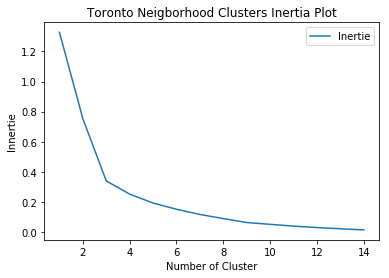

In [27]:
# Ploting de results
Downtown_Toronto_Inertia_Df.index = Downtown_Toronto_Inertia_Df.index.map(int)
Downtown_Toronto_Inertia_Df.plot(kind='line')

plt.title('Toronto Neigborhood Clusters Inertia Plot')
plt.ylabel('Innertie')
plt.xlabel('Number of Cluster')

plt.show() 

#### Manhattan

In [28]:
# define the dataframe columns
manhattan_Inertia_Col = ['ClusterNumber', 'Inertie'] 

# instantiate the dataframe
manhattan_Inertia_Df = pd.DataFrame(columns=manhattan_Inertia_Col)

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
for k in range (1, 15):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    manhattan_manhattan_kmeans_model = KMeans(n_clusters=k, random_state=1).fit(manhattan_grouped_clustering)
    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    #manhattan_manhattan_labels = manhattan_manhattan_kmeans_model.labels_[0:10]
    # Sum of distances of samples to their closest cluster center
    manhattan_inertia = manhattan_manhattan_kmeans_model.inertia_
    #print ("k:",k, " cost:", manhattan_interia)
    manhattan_Inertia_Df = manhattan_Inertia_Df.append({'ClusterNumber': k,
                                          'Inertie': manhattan_inertia,
                                                     }, ignore_index=True)


In [29]:
manhattan_Inertia_Df=manhattan_Inertia_Df.set_index("ClusterNumber")   

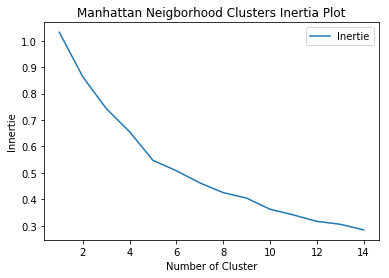

In [30]:
#import matplotlib.pyplot as plt
# Ploting de results
manhattan_Inertia_Df.index = manhattan_Inertia_Df.index.map(int)
manhattan_Inertia_Df.plot(kind='line')

plt.title('Manhattan Neigborhood Clusters Inertia Plot')
plt.ylabel('Innertie')
plt.xlabel('Number of Cluster')

plt.show() 

**What sizes:**

In Downtown Toronto Clustering the Elbow is more evident at glence that in Manhattan Clustering. I choose 3 for Toronto and 8 for Manhattan. Why not 2 or 5 for Manhattan? Because at 8 the inertia is close to Toronto Downtown. This is a choice to be approximatively on the same level of comparison.

**Conclusion:**

Here we can clearly tell Manhattan Neigborhood is more diverse than Downtown Toronto. This maybe mean you have to go to some Specific Boroughs if you want to easyly find some venues.

### Cluster Analysis Modeling

#### Downtown Toronto

In [31]:
# set number of clusters
kclusters = 3

# run k-means clustering
Downtown_Toronto_kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(Downtown_Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
Downtown_Toronto_kmeans_model.labels_[0:5] 

# add clustering labels
Downtown_Toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', Downtown_Toronto_kmeans_model.labels_)

Downtown_Toronto_merged = Downtown_Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Downtown_Toronto_merged = Downtown_Toronto_merged.join(Downtown_Toronto_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#### Manhattan

In [32]:
# set number of clusters
kclusters = 8

# run k-means clustering
manhattan_kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
manhattan_kmeans_model.labels_[0:7] 

# add clustering labels
manhattan_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', manhattan_kmeans_model.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

### Showing Clusters as Dataframe

#### Downtown Toronto

In [33]:
print ('Downtown Toronto Cluster 1:')
DowntownC1=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 0, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]
for X in range(1,6):
    print(DowntownC1[columns[X]].value_counts())
DowntownC1

Downtown Toronto Cluster 1:
Shop/Store          13
Grocery              1
Other Food Place     1
Asian Restaurant     1
Name: 1st Most Common Venue, dtype: int64
Other Food Place       6
European Restaurant    2
Shop/Store             2
Asian Restaurant       2
Coffee Shop            2
Bar                    1
Bakery                 1
Name: 2nd Most Common Venue, dtype: int64
Other Food Place       5
Bar                    3
European Restaurant    3
Asian Restaurant       3
Shop/Store             1
Coffee Shop            1
Name: 3rd Most Common Venue, dtype: int64
European Restaurant    5
Bar                    4
Hotel                  3
Gay Bar                1
Other Food Place       1
Park                   1
Coffee Shop            1
Name: 4th Most Common Venue, dtype: int64
European Restaurant    4
Asian Restaurant       3
Hotel                  2
Coffee Shop            2
Market                 1
Park                   1
Bar                    1
Bakery                 1
Art/Museum  

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,"Cabbagetown, St. James Town",Shop/Store,European Restaurant,Asian Restaurant,Other Food Place,Bakery
2,Church and Wellesley,Shop/Store,Asian Restaurant,Other Food Place,Gay Bar,European Restaurant
3,"Harbourfront, Regent Park",Shop/Store,Bakery,Coffee Shop,European Restaurant,Park
4,"Ryerson, Garden District",Shop/Store,Other Food Place,Asian Restaurant,Bar,European Restaurant
5,St. James Town,Shop/Store,European Restaurant,Other Food Place,Coffee Shop,Asian Restaurant
6,Berczy Park,Shop/Store,Bar,Other Food Place,European Restaurant,Market
7,Central Bay Street,Shop/Store,Asian Restaurant,Other Food Place,European Restaurant,Bar
8,"Adelaide, King, Richmond",Shop/Store,Other Food Place,Asian Restaurant,Bar,European Restaurant
9,"Harbourfront East, Toronto Islands, Union Station",Shop/Store,Other Food Place,European Restaurant,Hotel,Art/Museum
10,"Design Exchange, Toronto Dominion Centre",Shop/Store,Other Food Place,European Restaurant,Hotel,Coffee Shop


In this first cluster of Downtown Toronto we have mostly stores and restaurant. It is typically the description of city center.

In [34]:
print ('Downtown Toronto Cluster 2:')
DowntownC2=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 1, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]
for X in range(1,6):
    print(DowntownC2[columns[X]].value_counts())
DowntownC2

Downtown Toronto Cluster 2:
Park    1
Name: 1st Most Common Venue, dtype: int64
Trail    1
Name: 2nd Most Common Venue, dtype: int64
Playground    1
Name: 3rd Most Common Venue, dtype: int64
European Restaurant    1
Name: 4th Most Common Venue, dtype: int64
Caribbean Restaurant    1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Rosedale,Park,Trail,Playground,European Restaurant,Caribbean Restaurant


We have only **Rosedale** in This cluster. 

We can read this about it on wikipedia:

"Rosedale is an upscale neighborhood in the city of Toronto, Canada. Former estate of William Botsford Jarvis, businessman and political figure of Upper Canada in the 19th century, located in the north end of downtown Toronto, north of the Wellesley and St. James Ward and Church neighborhoods Town, and east of Yorkville and The Annex. It is, along with two other active neighborhoods in Toronto, Forest Hill and Bridle Path, one of Toronto's highest living neighborhoods, with an annual household income of $ 245,0001.

The area is served by two Toronto subway stations: Rosedale to the west, and Castle Frank to the southeast."
...
"Rosedale est construit parmi trois ravins, préservés comme un parc. Rosedale regorge de sacs et de routes sinueuses traversant le quartier, qui, associées à d'autres limites physiques (telles que les ravins et les ponts), entraînent une faible circulation automobile. Même si Rosedale est située au centre de Toronto, on ne peut pratiquement pas entendre parler d'un véhicule avec l'abondance d'arbres et de feuillages qui entourent la communauté. Les maisons sont principalement des maisons unifamiliales isolées, dont beaucoup ont au moins 100 ans et des anciennes fermes plus proches de 200. Les maisons vont de l’Edwardian à la Tudor en victorien et en géorgien."

We don't have shops in this Borough and the only one kind of Restaurant we have their is European and Carribbean.

In [35]:
print ('Downtown Toronto Cluster 3:')
DowntownC3=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 2, Downtown_Toronto_merged.columns[[1] + list(range(5, Downtown_Toronto_merged.shape[1]))]]
for X in range(1,6):
    print(DowntownC3[columns[X]].value_counts())
DowntownC3

Downtown Toronto Cluster 3:
Airport    1
Name: 1st Most Common Venue, dtype: int64
Harbor / Marina    1
Name: 2nd Most Common Venue, dtype: int64
Plane    1
Name: 3rd Most Common Venue, dtype: int64
Art/Museum    1
Name: 4th Most Common Venue, dtype: int64
Boat or Ferry    1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport,Harbor / Marina,Plane,Art/Museum,Boat or Ferry


We have **CN Tower, Bathurst Quay, Island airport and Harbo** in This cluster. 

*CN Tower:* The CN Tower is a 553.33-meter tower located in downtown Toronto, Canada, which has become the symbol of this city.

*Bathurst Quay:* It was once the site of the World War II Training Base used by the Norwegian Air Force.The Quay includes Little Norway and Ireland Parks and is home to the old Canada Maltin Silos and the Bathurst Ferry         Terminal to Billy Bishop Toronto City Airport.

*Island airport:* The airport was established in 1930 as the city's main airport, and was completed in 1939.

*Harbo:* Toronto Harbour or Toronto Bay is a bay on the north shore of Lake Ontario, in Toronto, Ontario, Canada. It is a natural harbour, protected from Lake Ontario waves by the Toronto Islands. Today, the harbour is used primarily for recreational boating, including personal vessels and pleasure boats providing scenic or party cruises. 

I don't know why those place are considered as the same Borough  by the API but they are all near Lake ontario and are the place to find Airport, Museum and Boat. No shop, no restaurant

#### Manhattan


In [36]:
print ('Manhattan Cluster 1')
Manhattan_C1= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C1[columns[X]].value_counts())
Manhattan_C1

Manhattan Cluster 1
Shop/Store    2
Name: 1st Most Common Venue, dtype: int64
Other Food Place    2
Name: 2nd Most Common Venue, dtype: int64
Yoga Studio            1
European Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
Women's Store    1
Bank             1
Name: 4th Most Common Venue, dtype: int64
Art/Museum             1
American Restaurant    1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Shop/Store,Other Food Place,Yoga Studio,Bank,American Restaurant
23,Soho,Shop/Store,Other Food Place,European Restaurant,Women's Store,Art/Museum


In this first cluster of Manhattan we have mostly stores and food place. 

In [37]:
print ('Manhattan Cluster 2')
Manhattan_C2= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C2[columns[X]].value_counts())
Manhattan_C2

Manhattan Cluster 2
Shop/Store    14
Name: 1st Most Common Venue, dtype: int64
European Restaurant    7
Asian Restaurant       4
Other Food Place       2
Sport place            1
Name: 2nd Most Common Venue, dtype: int64
Other Food Place       6
Asian Restaurant       4
Bar                    3
European Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
Asian Restaurant             4
Other Food Place             3
Sport place                  2
American Restaurant          2
Bar                          1
Exhibit                      1
Latin American Restaurant    1
Name: 4th Most Common Venue, dtype: int64
Bar                    6
European Restaurant    3
Sport place            1
Other Food Place       1
Asian Restaurant       1
Art/Museum             1
Coffee Shop            1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Washington Heights,Shop/Store,Other Food Place,Asian Restaurant,Latin American Restaurant,Coffee Shop
8,Upper East Side,Shop/Store,European Restaurant,Other Food Place,Exhibit,Art/Museum
9,Yorkville,Shop/Store,Asian Restaurant,Other Food Place,Sport place,Bar
10,Lenox Hill,Shop/Store,European Restaurant,Other Food Place,Asian Restaurant,Sport place
12,Upper West Side,Shop/Store,Asian Restaurant,European Restaurant,Other Food Place,Bar
17,Chelsea,Shop/Store,European Restaurant,Other Food Place,Asian Restaurant,Bar
18,Greenwich Village,Shop/Store,European Restaurant,Asian Restaurant,Other Food Place,Bar
19,East Village,Shop/Store,Asian Restaurant,Bar,Other Food Place,European Restaurant
24,West Village,Shop/Store,European Restaurant,Bar,American Restaurant,Asian Restaurant
27,Gramercy,Shop/Store,Other Food Place,Bar,Asian Restaurant,European Restaurant


In this 2nd cluster of Manhattan we have mostly stores and Asian/European Restaurant.

In [38]:
print ('Manhattan Cluster 3')
Manhattan_C3= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C3[columns[X]].value_counts())
Manhattan_C3

Manhattan Cluster 3
Shop/Store          2
Other Food Place    2
Asian Restaurant    2
Name: 1st Most Common Venue, dtype: int64
European Restaurant    3
Shop/Store             1
Other Food Place       1
Asian Restaurant       1
Name: 2nd Most Common Venue, dtype: int64
Other Food Place       2
Bar                    1
European Restaurant    1
Theater                1
Shop/Store             1
Name: 3rd Most Common Venue, dtype: int64
Shop/Store             2
Bar                    1
European Restaurant    1
Hotel                  1
Other Food Place       1
Name: 4th Most Common Venue, dtype: int64
Bar                          2
European Restaurant          1
Sport place                  1
Asian Restaurant             1
Latin American Restaurant    1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Clinton,Other Food Place,Shop/Store,Theater,Bar,European Restaurant
16,Murray Hill,Other Food Place,Asian Restaurant,Shop/Store,European Restaurant,Bar
21,Tribeca,Shop/Store,European Restaurant,Bar,Other Food Place,Asian Restaurant
35,Turtle Bay,Asian Restaurant,European Restaurant,Other Food Place,Shop/Store,Bar
36,Tudor City,Asian Restaurant,Other Food Place,European Restaurant,Shop/Store,Latin American Restaurant
39,Hudson Yards,Shop/Store,European Restaurant,Other Food Place,Hotel,Sport place


In this 3rd cluster of Manhattan we have mostly  Restaurant stores. 

In [39]:
print ('Manhattan Cluster 4')
Manhattan_C4= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C4[columns[X]].value_counts())
Manhattan_C4

Manhattan Cluster 4
Shop/Store    7
Name: 1st Most Common Venue, dtype: int64
Other Food Place      6
African Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
Asian Restaurant       2
Other Food Place       1
Art/Museum             1
Sport place            1
Park                   1
American Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
Park                   2
Hotel                  1
European Restaurant    1
Sport place            1
Bakery                 1
American Restaurant    1
Name: 4th Most Common Venue, dtype: int64
Bar                    2
European Restaurant    1
Hotel                  1
Playground             1
Art/Museum             1
School/Education       1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Central Harlem,Shop/Store,African Restaurant,Other Food Place,American Restaurant,Art/Museum
11,Roosevelt Island,Shop/Store,Other Food Place,Park,Sport place,Playground
15,Midtown,Shop/Store,Other Food Place,Asian Restaurant,Hotel,Bar
22,Little Italy,Shop/Store,Other Food Place,Asian Restaurant,Bakery,European Restaurant
26,Morningside Heights,Shop/Store,Other Food Place,American Restaurant,Park,School/Education
28,Battery Park City,Shop/Store,Other Food Place,Art/Museum,Park,Hotel
29,Financial District,Shop/Store,Other Food Place,Sport place,European Restaurant,Bar


In this 4th cluster of Manhattan we have mostly stores and Food Places.

In [40]:
print ('Manhattan Cluster 5')
Manhattan_C5= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C5[columns[X]].value_counts())
Manhattan_C5

Manhattan Cluster 5
Bar    1
Name: 1st Most Common Venue, dtype: int64
Boat or Ferry    1
Name: 2nd Most Common Venue, dtype: int64
Park    1
Name: 3rd Most Common Venue, dtype: int64
Playground    1
Name: 4th Most Common Venue, dtype: int64
Sport place    1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,Stuyvesant Town,Bar,Boat or Ferry,Park,Playground,Sport place


In this 5th cluster of Manhattan we have mostly Bars and Boat. This seems to be a particular Borough as it is a residential one. We can read on wikipdia:
"Stuyvesant Town–Peter Cooper Village is a large, post-World War II private residential development on the east side of the New York City borough of Manhattan. The complex consists of 110 red brick apartment buildings on an 80-acre (32 ha) tract stretching from First Avenue to Avenue C, between 14th and 23rd Streets."

In [41]:
print ('Manhattan Cluster 6')
Manhattan_C6= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C6[columns[X]].value_counts())
Manhattan_C6

Manhattan Cluster 6
Shop/Store                   1
Other Food Place             1
Latin American Restaurant    1
Name: 1st Most Common Venue, dtype: int64
Other Food Place    2
Shop/Store          1
Name: 2nd Most Common Venue, dtype: int64
Shop/Store                   1
Asian Restaurant             1
Latin American Restaurant    1
Name: 3rd Most Common Venue, dtype: int64
Bakery                       1
Latin American Restaurant    1
Coffee Shop                  1
Name: 4th Most Common Venue, dtype: int64
Bar                    1
European Restaurant    1
Deli / Bodega          1
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Inwood,Shop/Store,Other Food Place,Latin American Restaurant,Coffee Shop,European Restaurant
4,Hamilton Heights,Other Food Place,Shop/Store,Asian Restaurant,Latin American Restaurant,Bar
7,East Harlem,Latin American Restaurant,Other Food Place,Shop/Store,Bakery,Deli / Bodega


In this 6th cluster of Manhattan we have mostly Food places and Shops and Boat. 

In [42]:
print ('Manhattan Cluster 7')
Manhattan_C7= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C7[columns[X]].value_counts())
Manhattan_C7

Manhattan Cluster 7
Asian Restaurant    3
Shop/Store          2
Name: 1st Most Common Venue, dtype: int64
Shop/Store          3
Asian Restaurant    2
Name: 2nd Most Common Venue, dtype: int64
Other Food Place    4
Hotel               1
Name: 3rd Most Common Venue, dtype: int64
Bar                          1
European Restaurant          1
Other Food Place             1
Art/Museum                   1
Latin American Restaurant    1
Name: 4th Most Common Venue, dtype: int64
European Restaurant          3
Latin American Restaurant    2
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Asian Restaurant,Shop/Store,Other Food Place,Bar,European Restaurant
5,Manhattanville,Asian Restaurant,Shop/Store,Other Food Place,European Restaurant,Latin American Restaurant
20,Lower East Side,Shop/Store,Asian Restaurant,Other Food Place,Art/Museum,Latin American Restaurant
25,Manhattan Valley,Asian Restaurant,Shop/Store,Other Food Place,Latin American Restaurant,European Restaurant
33,Midtown South,Shop/Store,Asian Restaurant,Hotel,Other Food Place,European Restaurant


In this 7th cluster of Manhattan we have mostly Asian Restaurant and Shops. We can notice Chinatown in this cluster.

In [43]:
print ('Manhattan Cluster 8')
Manhattan_C8= manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 7, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
for X in range(1,6):
    print(Manhattan_C8[columns[X]].value_counts())
Manhattan_C8

Manhattan Cluster 8
Shop/Store    2
Name: 1st Most Common Venue, dtype: int64
European Restaurant    2
Name: 2nd Most Common Venue, dtype: int64
Sport place    2
Name: 3rd Most Common Venue, dtype: int64
Bakery     1
Theater    1
Name: 4th Most Common Venue, dtype: int64
Other Food Place    2
Name: 5th Most Common Venue, dtype: int64


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Lincoln Square,Shop/Store,European Restaurant,Sport place,Theater,Other Food Place
32,Civic Center,Shop/Store,European Restaurant,Sport place,Bakery,Other Food Place


In this 8th cluster of Manhattan we have mostly shops and Restaurant. 

## Result and discussion<a name="results"></a>

In this cluster analysis of Downtown Toronto and Manhattan Neighbordhood we have seen that Manhattan is more diverse than Downtown Toronto in the structure of their Neighborhood. Approximativement the same inertia Manhattan has more cluster than Downtown Toronto. In addition the elbow point for Downtown Toronto is easer to identify than for Manhathan. We choose 3 for Manhattan and 8 for Downtown Toronto.

Globaly these two Financial Districts Neighbordhood are structured as follow:

In Downtown Toronton  the 3 clusters are airport area located in an island with airport comodities, quay and Museums; Rosedale an upscale Borough with park playground and Restaurant;and the others (Mainly Restaurant and shops).

In Manhattan the 8 clusters are have most thing in common than Downtown Toronton clusters. We have a first subcluster where venues are mosly Shops (1,2,4,8), a second subcluster where venues are mosly fifty fifty Restaurant and Shops (3,6,7) and a third subcluster where the main venue category are Bars:

**Subcuster 1:** 
In the cluster 1 we have Soho and Marble Hill. In reality Soho refers to art and fashion and can see that in venues around. marbel Hill is the only Neighborhood of Manhattan that is not and Island. finally theseare two atypic places where u find venue that are not common + shops and restaurants.

In cluster 2 we only have shops Restaurant and Bar mostly. The Restaurant are mostly Asian.


In cluster 4 we only have  plus shops and Restaurant Hotel, Parks, Schools, Coffee Shops. It is most diverse than the 2nd in term of venues category.

In cluster 8 is also diverse than the 2nd but with sport places, Park, Theater. It is where we found mostly sport place.

**Subcuster 2:** 
In cluster 3 we only mostly Asian/European Restaurant and Other food places/no one specialy very présent. There are also shops and Bars.

In cluster 6 we only mostly latin Restaurant.

In cluster 7 we only mostly Asian Restaurant and Shop mosly. Plus we have some european restaurant.

**Subcuster 3:** 

This subcluster has only one Borough (Stuyvesant town in the east side)the main venue category are Bars boats.

Finally Manhattan clustering was the most ambigus as there is not real differences beetween clusters out of the order of the venue category counts. Sometime non common venues make the diffrence. My study is an overview and it remain global. It is possible to studies some specificities like focusing on food places with some additionnal information on their size, their menus... There was also not real informations about local food restaurant. above all it was a good exercise to have an idea of the two places.

Clearly Manhattan has most venue than Downtown toronto and that maybe explain his the diveristy. The number venue categories you can find in Manhattan neighborhood is also higher than that you can find in Downtown Toronto but not in Manhattan neighborhood. This fact explain also the number of clusters in Manhattan compare to Downtown Toronto.

In [44]:
#Place that are in ManHattan and But not in Downtown Toronto 
a=manhattan_venues_1
b=Downtown_Toronto_venues_1
d=a.isin(b)
print('Place that are in ManHattan and But not in Downtown Toronto ')
a[~d].unique()

Place that are in ManHattan and But not in Downtown Toronto 


array(['Tennis Stadium', 'Supplement Shop', 'Big Box Store',
       'English Restaurant', 'Garden Center', 'Roof Deck',
       'Indie Movie Theater', 'Malay Restaurant', 'Bike Shop',
       'Hotpot Restaurant', 'Spanish Restaurant', 'Nail Salon', 'Boutique',
       'Paper / Office Supplies Store', 'Shanghai Restaurant',
       'Austrian Restaurant', 'Wine Shop', 'Tapas Restaurant',
       'Frozen Yogurt Shop', 'Pool', 'Mobile Phone Shop',
       'Arepa Restaurant', 'Rental Car Location', 'Rest Area',
       "Women's Store", 'Kids Store', 'Shipping Store', 'Veterinarian',
       'Intersection', 'Bus Station', 'School', 'Climbing Gym',
       'Other Nightlife', 'Bike Trail', 'Japanese Curry Restaurant',
       'Beer Garden', 'Cuban Restaurant', 'Music School', 'Cycle Studio',
       'Library', 'African Restaurant', 'Cafeteria',
       'Southern / Soul Food Restaurant', 'Public Art', 'Bridal Shop',
       'Exhibit', 'Turkish Restaurant', 'Video Store', 'Hot Dog Joint',
       'Peruvian Re

In [45]:
#Place that are in Downtown Toronto and But not in ManHattan
a=manhattan_venues_1
b=Downtown_Toronto_venues_1
e=b.isin(a)
print('Place that are in Downtown Toronto and But not in Manhattan')
b[~e].unique()

Place that are in Downtown Toronto and But not in Manhattan


array(['Theme Restaurant', 'Brewery', 'Comic Shop', 'Tanning Salon',
       'College Rec Center', 'Other Great Outdoors', 'Lake',
       'Poutine Place', 'Church', 'Smoothie Shop',
       'Comfort Food Restaurant', 'Belgian Restaurant',
       'Basketball Stadium', 'Beach', 'Neighborhood', 'General Travel',
       'Colombian Restaurant', 'Gluten-free Restaurant', 'Skating Rink',
       'Aquarium', 'Train Station', 'Baseball Stadium',
       'College Arts Building', 'Doner Restaurant', 'Hospital', 'Airport',
       'Airport Lounge', 'Airport Food Court', 'Airport Terminal',
       'Airport Gate', 'Plane', 'Airport Service'], dtype=object)

## Conclusion <a name="conclusion"></a>

The objective of this studies was to compare two financials district in the world and we choose Toronto and Manhattan. They appear very different in term of structure as Manhattan is more diverse. The most venues of theese place were shops restaurant, hotels...and it is very typical of bussiness areas. We also found some place near the water with boats... Something interestant was also that we found an aeroport in Downtown Toronto neighborhood but not in Manhathan Neighborhood.

## Clusters on map <a name="clustersmap"></a>

### Downtown Toronto

In [46]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map
Downtown_Toronto_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Downtown_Toronto_merged['Latitude'], Downtown_Toronto_merged['Longitude'], Downtown_Toronto_merged['Neighborhood'], Downtown_Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Downtown_Toronto_clusters_map)
Downtown_Toronto_clusters_map

### Manhattan

In [47]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="NY_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map
manhattan_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(manhattan_clusters_map)      
manhattan_clusters_map